# Validating Multi-View Spherical KMeans by Replicating Paper Results

Here we will validate the implementation of multi-view spherical kmeans by replicating the right side of figure 3 from the Multi-View Clustering paper by Bickel and Scheffer. 

In [2]:
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import scipy as scp
from scipy import sparse
import mvlearn
from mvlearn.cluster.mv_spherical_kmeans import MultiviewSphericalKMeans
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') # Ignore warnings

### A function to recreate the artificial dataset from the paper

The experiment in the paper used the 20 Newsgroup dataset, which consists of around 18000 newsgroups posts on 20 topics. This dataset can be obtained from scikit-learn. To create the artificial dataset used in the experiment, 10 of the 20 classes from the 20 newsgroups dataset were selected and grouped into 2 groups of 5 classes, and then encoded as tfidf vectors. These now represented the 5 multi-view classes, each with 2 views (one from each group). 200 examples were randomly sampled from each of the 20 newsgroups, producing 1000 concatenated examples uniformly distributed over the 5 classes.

In [ ]:
NUM_SAMPLES = 200

#Load in the vectorized news group data from scikit-learn package
news = fetch_20newsgroups(subset='all')
all_data = np.array(news.data)
all_targets = np.array(news.target)
class_names = news.target_names

#A function to get the 20 newsgroup data
def get_data():    
    
    #Set class pairings as described in the multiview clustering paper
    view1_classes = ['comp.graphics','rec.motorcycles', 'sci.space', 'rec.sport.hockey', 'comp.sys.ibm.pc.hardware']
    view2_classes = ['rec.autos', 'sci.med','misc.forsale', 'soc.religion.christian','comp.os.ms-windows.misc']
    
    #Create lists to hold data and labels for each of the 5 classes across 2 different views
    labels =  [num for num in range(len(view1_classes)) for _ in range(NUM_SAMPLES)]
    labels = np.array(labels)
    view1_data = list()
    view2_data = list()
    
    #Randomly sample 200 items from each of the selected classes in view1
    for ind in range(len(view1_classes)):
        class_num = class_names.index(view1_classes[ind])
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view1_data.append(class_data[indices])
    view1_data = np.concatenate(view1_data)
    
    #Randomly sample 200 items from each of the selected classes in view2
    for ind in range(len(view2_classes)):
        class_num = class_names.index(view2_classes[ind])
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view2_data.append(class_data[indices])  
    view2_data = np.concatenate(view2_data)
    
    #Vectorize the data
    vectorizer = TfidfVectorizer()
    view1_data = vectorizer.fit_transform(view1_data)
    view2_data = vectorizer.fit_transform(view2_data)

    #Shuffle and normalize vectors
    shuffled_inds = np.random.permutation(NUM_SAMPLES * len(view1_classes))
    view1_data = sparse.vstack(view1_data)
    view2_data = sparse.vstack(view2_data)
    view1_data = np.array(view1_data[shuffled_inds].todense())
    view2_data = np.array(view2_data[shuffled_inds].todense())
    magnitudes1 = np.linalg.norm(view1_data, axis=1)
    magnitudes2 = np.linalg.norm(view2_data, axis=1)
    magnitudes1[magnitudes1 == 0] = 1
    magnitudes2[magnitudes2 == 0] = 1
    magnitudes1 = magnitudes1.reshape((-1,1))
    magnitudes2 = magnitudes2.reshape((-1,1))
    view1_data /= magnitudes1
    view2_data /= magnitudes2
    labels = labels[shuffled_inds]

    return view1_data, view2_data, labels

###  Function to compute cluster entropy

The function below is used to calculate the total clustering entropy using the formula described in the paper.

In [3]:
def compute_entropy(partitions, labels, k, num_classes):
    
    total_entropy = 0
    num_examples = partitions.shape[0]
    for part in range(k):
        labs = labels[partitions == part]
        part_size = labs.shape[0]
        part_entropy = 0
        for cl in range(num_classes):
            prop = np.sum(labs == cl) * 1.0 / part_size
            ent = 0
            if(prop != 0):
                ent = - prop * np.log2(prop)
            part_entropy += ent
        part_entropy = part_entropy * part_size / num_examples
        total_entropy += part_entropy
    return total_entropy

### Functions to Initialize Centroids and Run Experiment

The randSpherical function initializes the initial cluster centroids by taking a uniform random sampling of points on the surface of a unit hypersphere. The getEntropies function runs Multi-View Spherical Kmeans Clustering on the data with n_clusters from 1 to 10 once each. This function essentially runs one trial of the experiment.

In [4]:
def randSpherical(n_clusters, n_feat1, n_feat2):
    c_centers1 = np.random.normal(0, 1, (n_clusters, n_feat1))
    c_centers1 /= np.linalg.norm(c_centers1, axis=1).reshape((-1, 1))
    c_centers2 = np.random.normal(0, 1, (n_clusters, n_feat2))
    c_centers2 /= np.linalg.norm(c_centers2, axis=1).reshape((-1, 1))
    return [c_centers1, c_centers2]

In [7]:
def getEntropies():
    
    v1_data, v2_data, labels = get_data()
    
    entropies = list()
    for num in range(1,11):
        
        centers = randSpherical(num, v1_data.shape[1], v2_data.shape[1])
        kmeans = MultiviewSphericalKMeans(n_clusters=num, init=centers, n_init=1)
        pred = kmeans.fit_predict([v1_data, v2_data])
        ent = compute_entropy(pred, labels, num, 5)
        entropies.append(ent)
    print('done')
    return entropies

### Running multiple trials of the experiment

It was difficult to exactly reproduce the results from the Multi-View Clustering Paper because the experimentors randomly sampled a subset of the 20 newsgroup dataset samples to create the artificial dataset, and this random subset was not reported. Therefore, in an attempt to at least replicate the overall shape of the distribution of cluster entropy over the number of clusters, we resample the dataset and recreate the artificial dataset each trial. Therefore, each trial consists of resampling and recreating the artificial dataset, and then running Multi-view Spherical KMeans clustering on that dataset for n_clusters 1 to 10 once each. We performed 80 such trials and the results of this are shown below.

In [8]:
#Do spherical kmeans and get entropy values for each k for multiple trials
n_workers = 10
n_trials = 80
mult_entropies1 = Parallel(n_jobs=n_workers)(
    delayed(getEntropies)() for i in range(n_trials))  

### Experiment Results

We see the results of this experiment below. Here, we have more or less reproduced the shape of the distribution as seen in figure 3 from the Multi-view Clustering Paper.

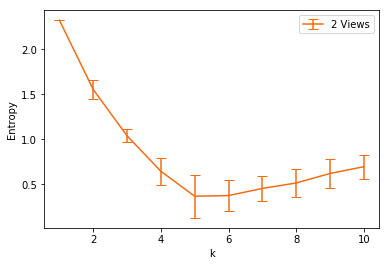

In [9]:
mult_entropies1 = np.array(mult_entropies1)
ave_m_entropies = np.mean(mult_entropies1, axis=0)
std_m_entropies = np.std(mult_entropies1, axis=0)
x_values = list(range(1, 11))
plt.errorbar(x_values, ave_m_entropies, std_m_entropies, capsize=5, color = '#F46C12')
plt.xlabel('k')
plt.ylabel('Entropy')
plt.legend(['2 Views'])
plt.rc('axes', labelsize=12)
plt.show()